# Example analysis notebook
### Author: Bill Flynn (bill.flynn@jax.org)

Major updates:
- 2018-09-28: creation
- 2018-12-10: reboot
- 2019-01-25: change import statement

This notebook is a template for analysis notebooks using the [`scanpy`](https://github.com/theislab/scanpy) package and an extension to their API I've written tentatively called [`scanpy_recipes`](https://https://github.com/TheJacksonLaboratory/scanpy_recipes).

The aim of the additional functions added to the `scanpy` API by `scanpy_recipes` are intended to simplify scRNA-seq analysis.  Additionally, it's meant to integrate seamlessly with the normal `scanpy` API and as such it only extends functionality.

Specifically, `scanpy` is normally loaded using `import scanpy as sc`.  Instead, this package provides this API **`from scanpy_recipes`**, e.g.

In [1]:
from scanpy_recipes import sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Running Scanpy 1.3.7 on 2019-01-28 13:15.


This is the same `scanpy.api` object, but has additional functionality.  

Also, note that scanpy's verbosity is turned up so that you can get feedback on exactly what your analysis is doing.  To have less verbosity, enter `sc.settings.verbosity = 0`.

# Key notes

1.  The major workflow will have you creating several `AnnData` objects.  By default, `scanpy` will modify `AnnData` objects inplace.  I find this can get confusing sometimes, especially since finding highly variable genes will remove all genes except the highly variable ones from the default expression matrix (they can still be found in the `AnnData.raw`).

    Instead, this workflow will:
    -   Start by loading `adata_raw`
    -   Generate `adata_qc` through QC processes
    -   Generate `adata_redux` through HVG selection, dimensionality reduction, and clustering.
    
    Each of these objects will be saved, and you can restart any step by loading the object output by the previous step.

2.  

## Loading data

The first major change to the analysis pipeline is to specify data upfront about the samples you will analyze.  To standardize this process, I've written a little parse and template.  

Below, we initialize the parser and print the template.  We then copy the template into a new cell, fill it in, then read it back into the parser which returns a `config` object.  This object is essentially just a dict of dicts which holds the template information.  We can then pass this `config` object to other functions and they will query it when needed for information.  Ultimately, most of this information gets passed onto and stored inside the `AnnData` objects which we will use to store the scRNA-seq data.

Eventually, much of this metadata will be generated automatically through our pipelines but while that is still coming up to speed, we will define it here below.

In [2]:
ac = sc.AnalysisConfig()

In [3]:
ac.print_template()

config_string = """
[names]
customer_name = EXAMPLE_TEXT
analyst_name = EXAMPLE_TEXT
analysis_name = EXAMPLE_TEXT

; these can be left blank or can be used
; to specify customer sample names
[sample_names]
EXAMPLE_SAMPLE1 =
EXAMPLE_SAMPLE2 = CD45+ stain
EXAMPLE_SAMPLE3 = CD45- stain

[genomes]
EXAMPLE_SAMPLE1 = EXAMPLE_GENOME1
EXAMPLE_SAMPLE2 = EXAMPLE_GENOME2
EXAMPLE_SAMPLE3 = EXAMPLE_GENOME3

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus

[input_dirs]
EXAMPLE_SAMPLE1 = EXAMPLE_DIR1
EXAMPLE_SAMPLE2 = EXAMPLE_DIR2
EXAMPLE_SAMPLE3 = EXAMPLE_DIR3

[output_dirs]
EXAMPLE_SAMPLE1 = EXAMPLE_DIR1
EXAMPLE_SAMPLE2 = EXAMPLE_DIR2
EXAMPLE_SAMPLE3 = EXAMPLE_DIR3

"""
The following sections are required:
['names', 'sample_names', 'genomes', 'species', 'input_dirs', 'output_dirs']


In [4]:
config_string = """
[names]
customer_name = Anonymous person
analyst_name = Bill Flynn
analysis_name = Test-analysis

[sample_names]
PR18031 = Pancrease CD45-

[genomes]
PR18031 = GRCh38

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus

[input_dirs]
PR18031 = /projects/singlecellcore/2018_Projects/PR18031/

[output_dirs]
PR18031 = /fastscratch/flynnb/test-outputs
"""
config = ac.read(config_string)

In [5]:
adata_raw = sc.load_10x_data("PR18031", config)

reading /projects/singlecellcore/2018_Projects/PR18031/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:01.26)
Ran `.var_names_make_unique()` for you.


This will automatically load lots of relevant **sample-level** metadata into the `AnnData` object:

In [6]:
print(adata_raw)
print("\nSample level metadata:")
for key, value in adata_raw.uns.items():
    print(f"{key:<20}{value}")

AnnData object with n_obs × n_vars = 4585 × 33694 
    obs: 'sequencing_saturation'
    var: 'gene_ids'
    uns: '10x_metrics', 'sampleid', 'sample_name', 'genome', 'species', 'analyst', 'customer_name', 'analysis_version', 'date_created', 'input_file', 'input_dir', 'output_dir'

Sample level metadata:
10x_metrics         {'alignment': {'Reads Mapped to Genome': '95.4%', 'Reads Mapped Confidently to Genome': '92.9%', 'Reads Mapped Confidently to Intergenic Regions': '3.8%', 'Reads Mapped Confidently to Intronic Regions': '17.0%', 'Reads Mapped Confidently to Exonic Regions': '72.1%', 'Reads Mapped Confidently to Transcriptome': '68.8%', 'Reads Mapped Antisense to Gene': '1.0%'}, 'sequencing': {'Q30 Bases in Barcode': '97.6%', 'Q30 Bases in RNA Read': '80.7%', 'Q30 Bases in Sample Index': '97.3%', 'Q30 Bases in UMI': '97.9%'}, 'important': {'Estimated Number of Cells': '4,585', 'Mean Reads per Cell': '43,392', 'Median Genes per Cell': '2,212', 'Median UMI Counts per Cell': '6,240'}, 'sa

After each step, it's best if we save the current adata objects.  You need to supply the "suffix" or annotation for that `AnnData` object so that we can tell it apart from others (parsing a variable name from the variable is ***hard***).

This function will save them to an automatically generated name under their `.uns["output_dir"]` that you defined in the configuration object.  Alternatively, you can use the `sc.save_all_adata()` function, which will save all adata defined in the notebook.

In [7]:
raw_save_file = sc.save_adata(adata_raw, "raw")

Saving PR18031-raw_20190128.h5ad to /fastscratch/flynnb/test-outputs.


## Quality control and filtering

Analysis first starts by generating **per-cell** and **per-gene** metrics, that we can then use to filter the data.

In [8]:
adata_raw = sc.read_h5ad(raw_save_file)

In [9]:
sc.qc.gen_qc(adata_raw)

Several per-cell and per-gene metrics are computed here:
-   per-cell:
    -   `sequencing_satuation`
    -   `percent_mito`
    -   `hemoglobin_counts` (HBB/Hbb-bs counts)
    -   `n_counts` (UMI count across genes)
    -   `n_genes` (gene count)
-   per-gene:
    -   `n_counts` (UMI count across cells)
    -   `n_cells` (cell count)
Additionally, the number of total genes, cells, and empty cells are added to the sample annotations.

In [10]:
print(adata_raw)
print("\nSample level metadata:")
for key, value in adata_raw.uns.items():
    print(f"{key:<20}{value}")

AnnData object with n_obs × n_vars = 4585 × 33694 
    obs: 'sequencing_saturation', 'percent_mito', 'hemoglobin_counts', 'n_counts', 'n_genes'
    var: 'gene_ids', 'n_counts', 'n_cells'
    uns: '10x_metrics', 'analysis_version', 'analyst', 'customer_name', 'date_created', 'genome', 'input_dir', 'input_file', 'output_dir', 'sample_name', 'sampleid', 'species', '10x_umi_cutoff', 'raw_cells', 'raw_genes', 'empty_genes', 'obs_titles'

Sample level metadata:
10x_metrics         {'alignment': {'Reads Mapped Antisense to Gene': '1.0%', 'Reads Mapped Confidently to Exonic Regions': '72.1%', 'Reads Mapped Confidently to Genome': '92.9%', 'Reads Mapped Confidently to Intergenic Regions': '3.8%', 'Reads Mapped Confidently to Intronic Regions': '17.0%', 'Reads Mapped Confidently to Transcriptome': '68.8%', 'Reads Mapped to Genome': '95.4%'}, 'important': {'Estimated Number of Cells': '4,585', 'Mean Reads per Cell': '43,392', 'Median Genes per Cell': '2,212', 'Median UMI Counts per Cell': '6,240'

The best way I can think of how to interact with these data to perform QC is to do a "dry run" or trial run of the QC filtering.  To do so, let's first plot how the raw distributions of the per-cell quantities:

hemoglobin_counts False
n_counts False
n_genes False
percent_mito False
sequencing_saturation False


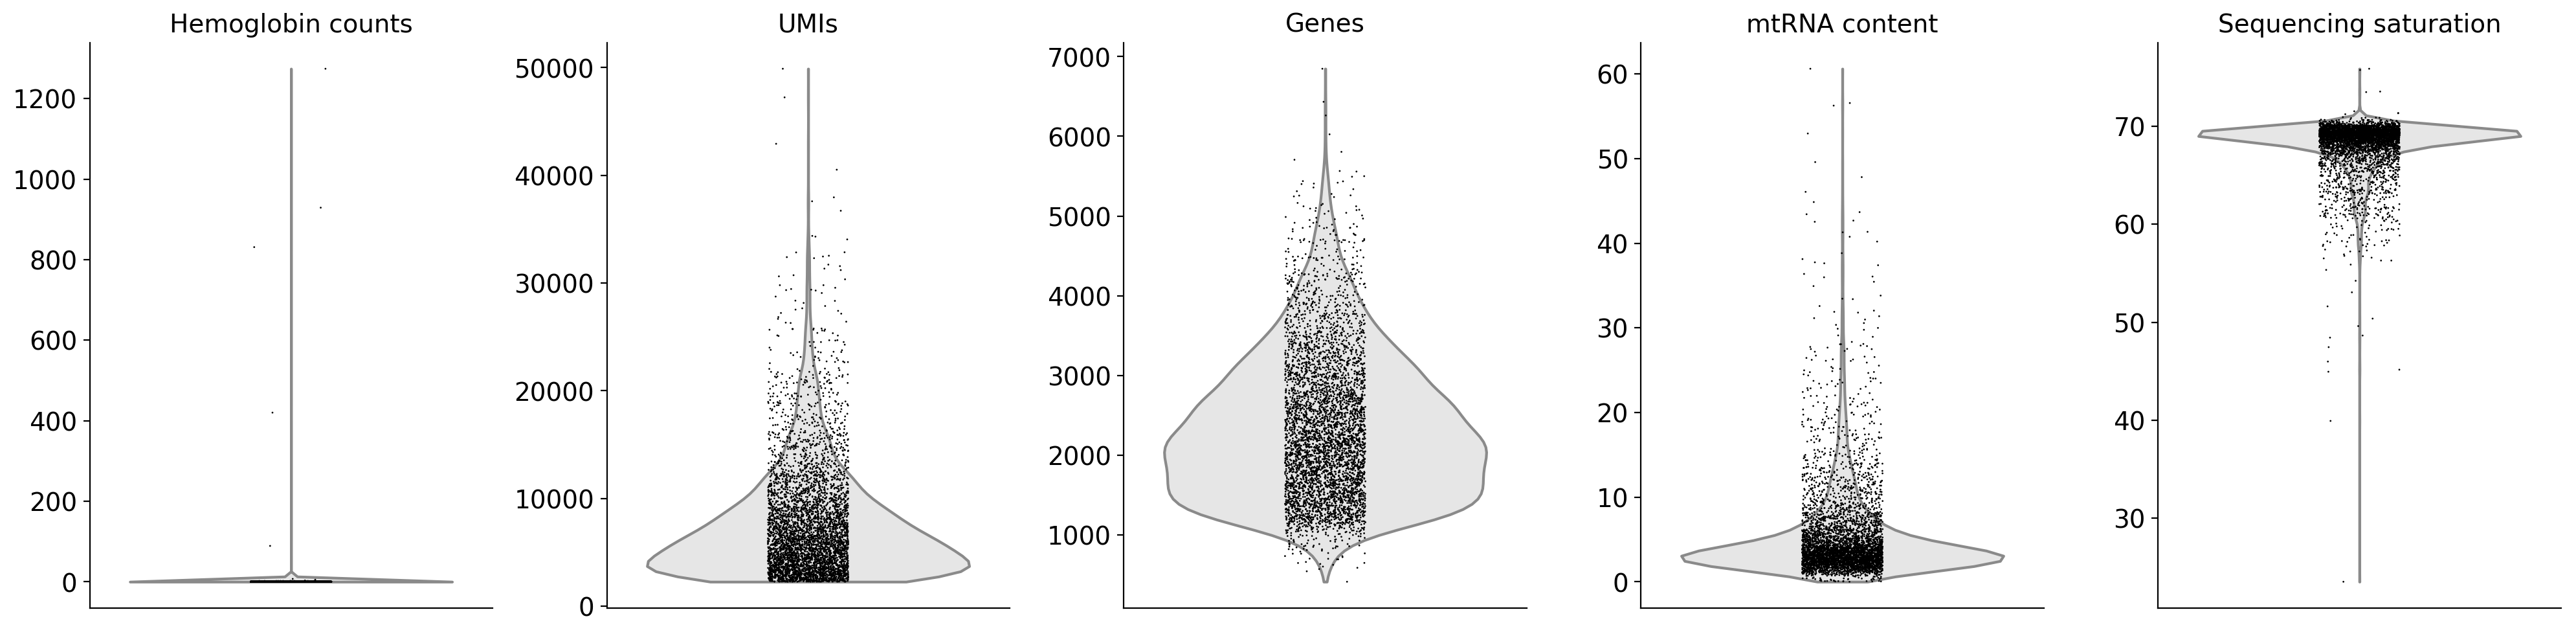

In [11]:
sc.pl.qc_violins(adata_raw)

Given these distributions, we can set thresholds for each variable in addition to standard cell and gene filters:
-   exclude genes with fewer than `min_counts_per_gene` in fewer than `min_cells_per_gene` (e.g. fewer than 3 counts in fewer than 3 cells)
-   exclude cells with fewer than `min_counts_per_cell` (UMIs) or fewer than `min_genes_per_cell`.
-   exclude cells with sequencing saturation below `sequencing_saturation`
-   exclude cells with mtRNA content greater than `percent_mito`%
-   exclude cells with more than `rbc_threshold` hemoglobin gene counts

If you don't want to threshold/filter by a criteria (like sequencing saturation or RBCs), just set those to `None`.

If we know exactly what we want, we can go ahead and set these filter values which will return a copy of the filtered AnnData object.  However, if we're unsure, we can pass the `trial = True` argument, which will return a copy of the *unfiltered* object with cells that would be removed annotated:
-   `adata.obs["qc_fail"]`: overall pass or fail annotation for each cell
-   `adata.obs["qc_fail_counts"]`: True if cell fails count thresholds
-   `adata.obs["qc_fail_seqsat"]`: True if cell fails sequencing saturation thresholds
-   `adata.obs["qc_fail_mito"]`: True if cell fails mtRNA content thresholds
-   `adata.obs["qc_fail_rbc"]`: True if cell fails hemoglobin thresholds

In [12]:
qc_params = dict(
    min_cells_per_gene=3,
    min_counts_per_gene=3,
    min_counts_per_cell=1000,
    min_genes_per_cell=500,
    sequencing_saturation=None,
    percent_mito=20.0, 
    rbc_threshold=10
)

In [13]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)

filtered out 13814 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 500 genes expressed
Original dims: (4585, 33694)
Filtered dims: (4451, 19880)


In [14]:
trial.obs.qc_fail.value_counts()

pass    4451
fail     134
Name: qc_fail, dtype: int64

Passing the `trial` object through the same violin plotting function returns similar plots with the cells that failed QC highlighted.  Metrics that were used for filtering will show the threshold level as a horizontal line.

hemoglobin_counts 10
n_counts 1000
n_genes 500
percent_mito 20.0
sequencing_saturation None


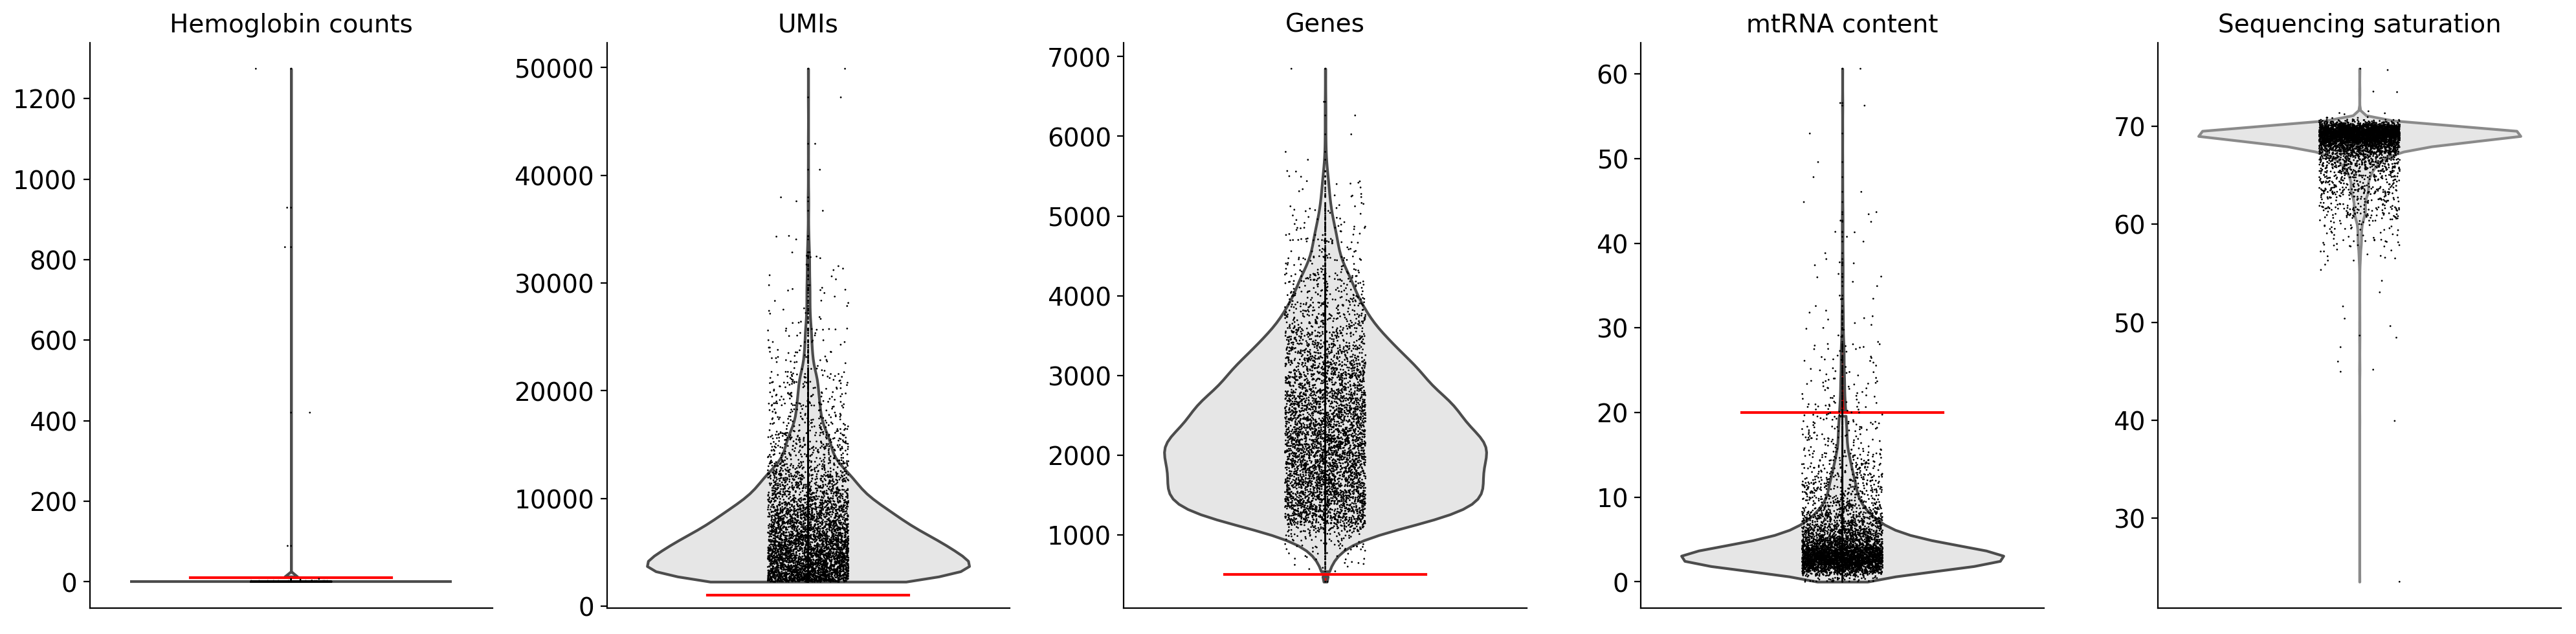

In [15]:
qc_fig1 = sc.pl.qc_violins(trial, return_fig=True)

Keep updating `qc_params` and regenerating the `trial` object until you get something you like.

Once we're comfortable with the appropriate filtering parameters, let's do the following so that we can generate additional QC plots.

In [16]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)
adata_qc = sc.qc.run_qc(adata_raw, trial=False, **qc_params)

filtered out 13814 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 500 genes expressed
Original dims: (4585, 33694)
Filtered dims: (4451, 19880)
filtered out 13814 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 500 genes expressed
Original dims: (4585, 33694)
Filtered dims: (4451, 19880)


In [17]:
trial.obs_keys()

['sequencing_saturation',
 'percent_mito',
 'hemoglobin_counts',
 'n_counts',
 'n_genes',
 'qc_fail_counts',
 'qc_fail_genes',
 'qc_fail_seqsat',
 'qc_fail_mito',
 'qc_fail_rbc',
 'qc_fail']

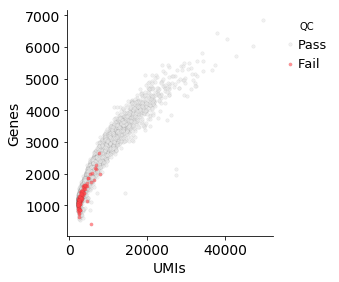

In [18]:
qc_fig2 = sc.pl.qc_pass_fail(trial, return_fig=True)

It will also be good to have control over the UMI rank plot that is used by CellRanger to call cells.  We can regenerate that here:

reading /projects/singlecellcore/2018_Projects/PR18031/raw_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:02.20)


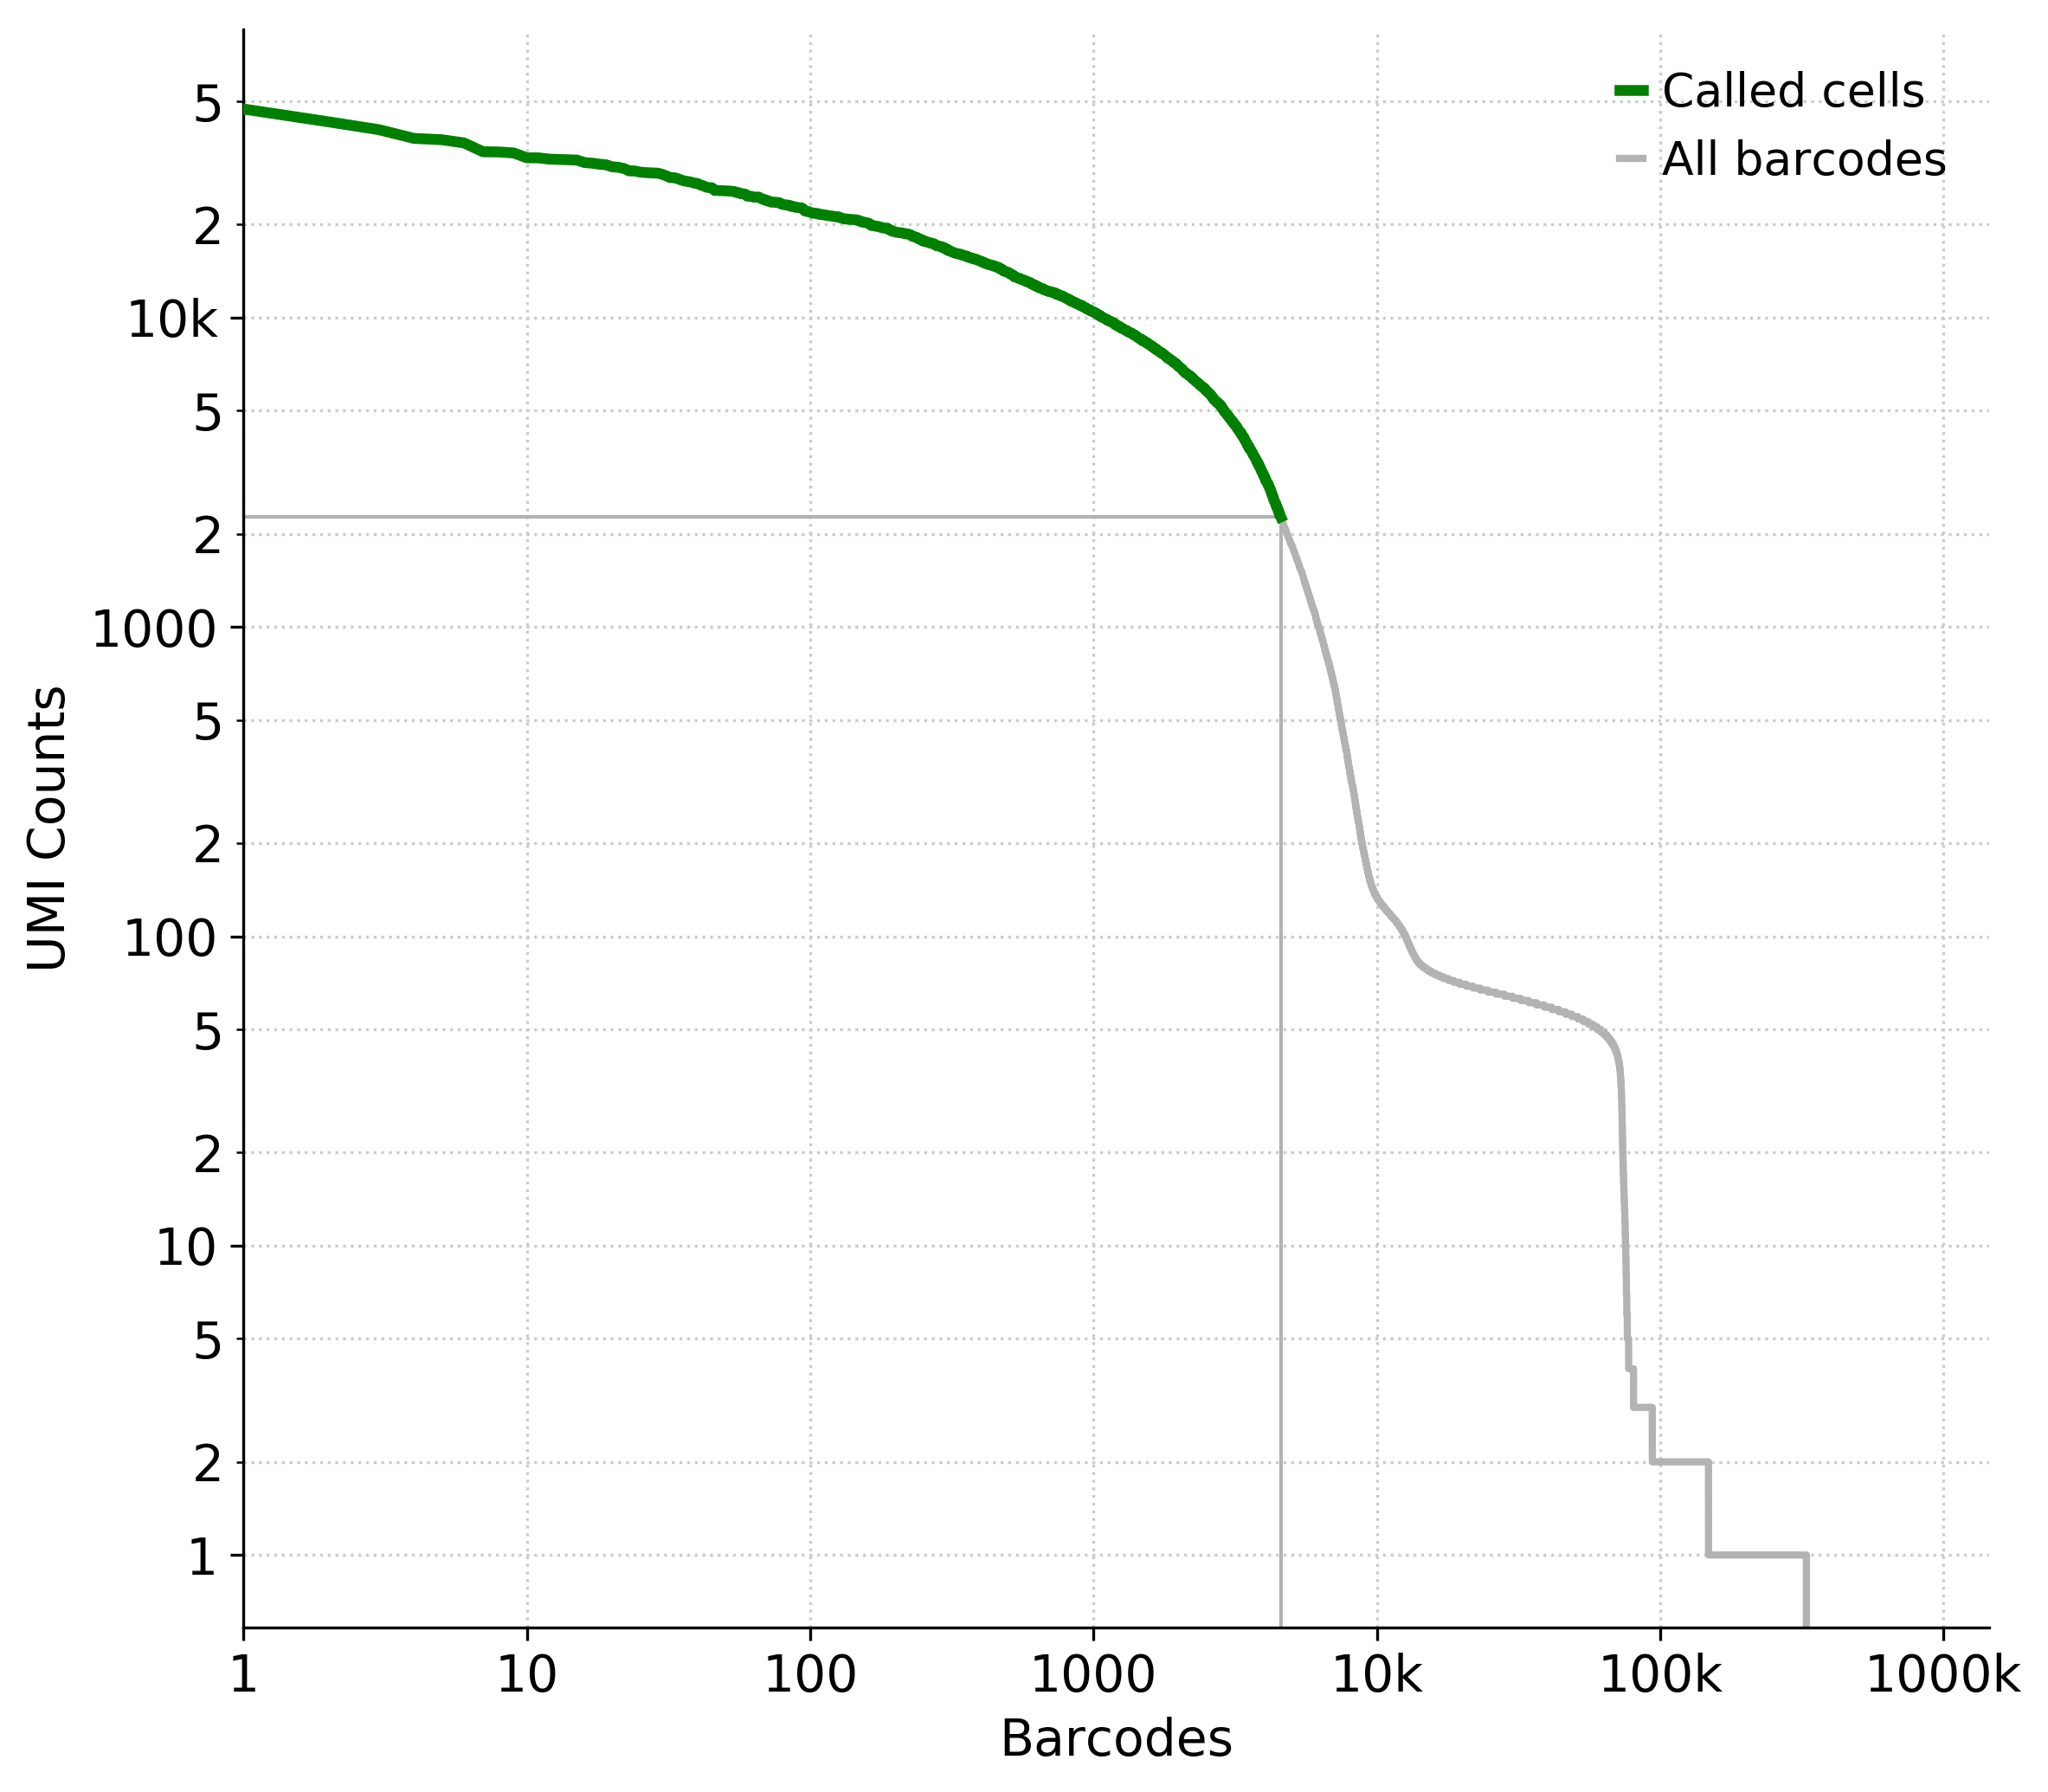

In [19]:
qc_fig3 = sc.pl.umi_rank_plot(adata_raw, return_fig=True)

This will ultimately become part of the report, but for now we can print out the QC filterering stats.

In [20]:
qc_message = (
    "After QC, the cell-gene matrix contains {cells} cells and {genes} genes.\n"
    "1.  {low_count_genes_removed} were removed due to too few counts.\n"
    "2.  {cells_removed} were removed due to several factors.\n"
    "2a.  {low_count_cells_removed} were removed due to low UMI and gene counts.\n"
    "2b.  {red_blood_cells_removed} were removed due to high counts of hemoglobin markers.\n"
    "2c.  {high_mtrna_cells_removed} were removed due to high mtRNA content.\n"
    "2d.  {low_sequencing_saturation_cells_removed} were removed due to low per-cell sequencing saturation.\n")
print(qc_message.format(**trial.uns["qc_metrics"]))

After QC, the cell-gene matrix contains 4451 cells and 19880 genes.
1.  13814 were removed due to too few counts.
2.  134 were removed due to several factors.
2a.  0 were removed due to low UMI and gene counts.
2b.  5 were removed due to high counts of hemoglobin markers.
2c.  128 were removed due to high mtRNA content.
2d.  0 were removed due to low per-cell sequencing saturation.



In [21]:
qc_save_file = sc.save_adata(adata_qc, "qc")

Saving PR18031-qc_20190128.h5ad to /fastscratch/flynnb/test-outputs.


## Highly variable gene selection and dimensionality reduction

Now that the data is filtered, we want to find highly variable genes and reduce the dimensionality of the data.  I've split this up into two steps:
1. `preprocess`
2. `dimensionality_reduction`

The first finds highly variable genes and normalizes, log transforms, and scales the data.  The default scanpy way to do this will just subset the `adata_qc` to only have the highly variable genes.  The way I've written does things differently, yielding two objects:
*   `adata_full`:
    -   `adata_full` contains log-transformed, normalized UMI counts for all genes.
    -   `adata_full.raw` contains normalized UMI counts for all genes (just `sc.pp.normalize_per_cell(adata_qc)`).
*   `adata_redux`:
    -   `adata_redux` contains scaled, log-transformed, normalized UMI counts for highly variable genes.
    -   `adata_redux.raw` contains normalized UMI counts for all genes (same as `adata_full.raw`).

In most cases, you won't use `adata_full`, but it's nice to keep it just in case you need the full normalized counts (as the `.raw` objects are hard to work with).  `adata_redux` is what will be used for dimensionality reduction and clustering.

The second computes PCA (50 components), a nearest-neighbor graph, and both 2 and 3 dimensional UMAP representations of the data from the `adata_redux` object.  I use the 2D representation to generate the plots for the initial report and the 3D representation for CellView.

In [22]:
adata_qc = sc.read_h5ad(qc_save_file)

The `preprocess` combines several of the same things as `scalpel.normalize_expression` and `scalpel.find_overdispersed_genes`.  So far, its only arguments are
-   `n_top_genes`: number of highly variable genes to find via the method used by CellRanger
-   `scale`: applies a standard scaling gene-wise, meaning that mean expression is shifted to 0 and variance is scaled to 1 for each gene.   

In [23]:
adata_full, adata_redux = sc.pp.preprocess(adata_qc, n_top_genes=1000, scale=True)

If you pass `n_top_genes`, all cutoffs are ignored.


In [24]:
print("adata_full:", adata_full.shape, "adata_full.raw:", adata_full.raw.X.shape)
print("adata_redux:", adata_redux.shape, "adata_redux.raw:", adata_redux.raw.X.shape)

adata_full: (4451, 19880) adata_full.raw: (4451, 19880)
adata_redux: (4451, 1000) adata_redux.raw: (4451, 19880)


Similarly, `dimensionality_reduction` provides a single interface to reduce the dimensionality of the data.  It will compute a nearest neighbor graph, and UMAP 2D and 3D embeddings.  It has the following options (so far):
- `n_comps`: number of PCA components to compute (default 50)
- `n_neighbors`: number of nearest neighbors, from 5-100, to use when building community graph (default 10)
- `min_dist`: UMAP specific parameter which determines how squished points can be; smaller values lead to more squishing.
- `metric`: distance metric to use for computing community graph (default "correlation")
- `match`: use 2D UMAP embedding to seed the 3D embedding so that they look similar (default False). Experimental.

In [25]:
sc.pp.dimensionality_reduction(adata_redux, n_neighbors=10, min_dist=0.5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:08.57) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:08.96) --> added
    'X_umap', UMAP coordinates (adata.obsm)
2D UMAP available at `.obsm['X_umap']`
3D UMAP available at `.obsm['X_umap_3d']`


In [26]:
for key in adata_redux.obsm_keys():
    print(key, adata_redux.obsm[key].shape)

X_pca (4451, 50)
X_umap (4451, 2)
X_umap_3d (4451, 3)


## Clustering

Our old pipelines used `DBSCAN`/`HDBSCAN` clustering in t-SNE space, which would only yield good clustering without major tweaking in a few datasets.  A good feature of that type of clustering was that it did not tend to "over-cluster", meaning you were much more likely to end up with large clusters that you may be interested in breaking up rather than combining.

On top of `scanpy.tl.leiden`/`scanpy.tl.louvain`, we've built several clustering helper functions to make clustering more intuitive.

-   `sc.tl.cluster` is just a wrapper around `sc.tl.leiden` which accepts a `resolution` parameter.
-   `sc.tl.subcluster` lets you try to find finer structure in a single or set of clusters in the current embedding and will return those new cluster labels under a new key.  This is helpful if a cluster is way too big or is split amongst several distinct areas of density in the embedding visualization.  This also accepts a `resolution` parameter to tune the clustering.
-   `sc.tl.combine_clusters` lets you do the opposite: merge two or more clusters into the same cluster.  Careful, as by default this function with shift the cluster numbers so there are no discontinuities by default (turn off with `shift_remaining=False`).
-   `sc.tl.reorder_clusters` lets you change the ordering of clusters so that, for example, clusters in a similar area are labeled consistently.

Each of these functions are showcased below.

In [27]:
sc.tl.cluster(adata_redux, resolution=1.0)

running Leiden clustering
    finished (0:00:00.63) --> found 25 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


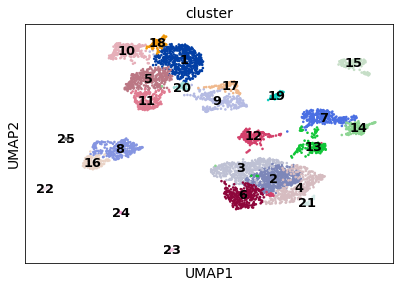

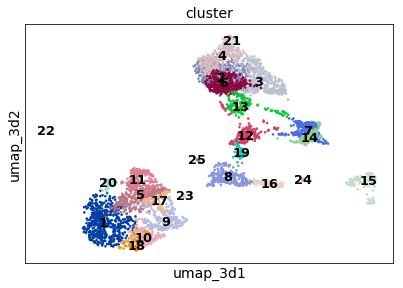

In [28]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")
sc.pl.scatter(adata_redux, basis="umap_3d", color="cluster", legend_loc="on data")

Sometimes, you may want to break apart certain clusters:

In [29]:
sc.tl.subcluster(adata_redux, cluster="13", cluster_key="cluster")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 3 clusters and added
    'cluster_R1', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R1']`.


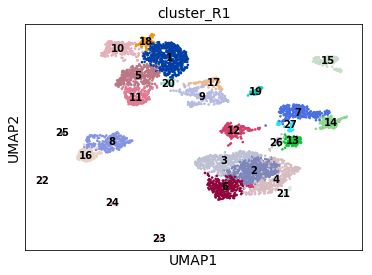

In [30]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

This can be done multiple times; just notice that the clustering key gets incremented each time.

In [31]:
sc.tl.subcluster(adata_redux, "9", cluster_key="cluster_R1")
sc.tl.subcluster(adata_redux, "15", cluster_key="cluster_R2")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'cluster_R2', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R2']`.
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 3 clusters and added
    'cluster_R3', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R3']`.


Other times, you may want to combine clusters together

In [32]:
sc.tl.combine_clusters(adata_redux, ["2", "3", "4", "6"], cluster_key="cluster_R3")

Updated clusters under `adata.obs['cluster_R3']`.


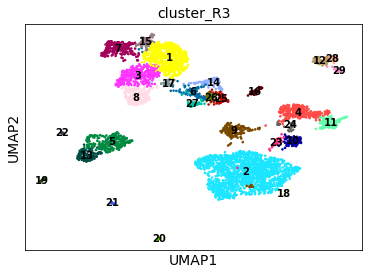

In [33]:
sc.pl.umap(adata_redux, color="cluster_R3", legend_loc="on data")

And lastly, you may want to reorder the cluster numbers so that clusters nearby share similar numbers

In [34]:
new_ordering = ["7", "15", "1", "3", "8"]
adata_redux.obs["cluster_final"] = sc.tl.reorder_clusters(adata_redux.obs["cluster_R3"], new_ordering)

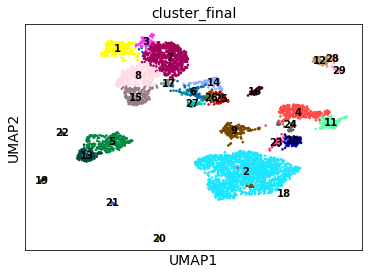

In [35]:
sc.pl.umap(adata_redux, color="cluster_final", legend_loc="on data")

You can use this to reorder the whole dataset:

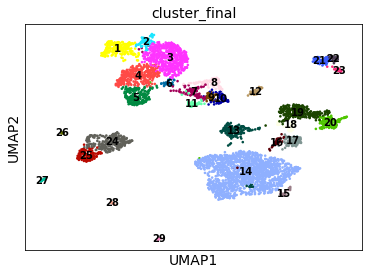

In [36]:
new_ordering = [
    "7", "15", "1", "3", "8", "17", 
    "6", "14", "26", "25", "27", "16", 
    "9", "2", "18", 
    "23", "10", "24", "4", "11", 
    "12", "28", "29",
    "5", "13", "22", "19", "21", "20"
]
adata_redux.obs["cluster_final"] = sc.tl.reorder_clusters(adata_redux.obs["cluster_R3"], new_ordering)
sc.pl.umap(adata_redux, color="cluster_final", legend_loc="on data")

## Marker gene detection

`scanpy` provides several ways to find marker genes via the `sc.tl.rank_genes_groups` function.  However, through some testing, it appears that the old way of finding markers in `scalpel` recovers many of the same top markers.  So I recoded `scalpel`'s marker detection to work with `AnnData` objects and renamed it `sc.tl.find_marker_genes`.  It's now pretty fast.

Markers will be returned from this function and also stored as `adata_redux.uns["auroc_markers"]` which can be retreived using the `sc.get_marker_dataframe(adata_redux)` function (we need this special function because the markers are stored internally in a weird format for read/write purposes).

In [41]:
markers = sc.tl.find_marker_genes(adata_redux, "cluster_final", log_fold_change=1.0)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Computed markers for 29 clusters.


In [42]:
markers.head()

,gene_name,AUROC,avg_diff,cluster_final
0,COL1A1,0.975903,2.522313,1
1,COL3A1,0.973147,2.385993,1
2,COL1A2,0.968906,2.218476,1
3,SFRP2,0.935036,1.840032,1
4,COL6A3,0.934004,1.431152,1


We can easily plot the genes using the `scanpy` built in `matrixplot`, `dotplot`, or `heatmap` functions.  Choose your favorite to visualize this data!  We may or may not include this in the report output.

When you're done, `export_markers` will automatically handle output file creation and will make a flat `.csv` and a multisheet `.xlsx` file (containing the exact same info, of course)!.

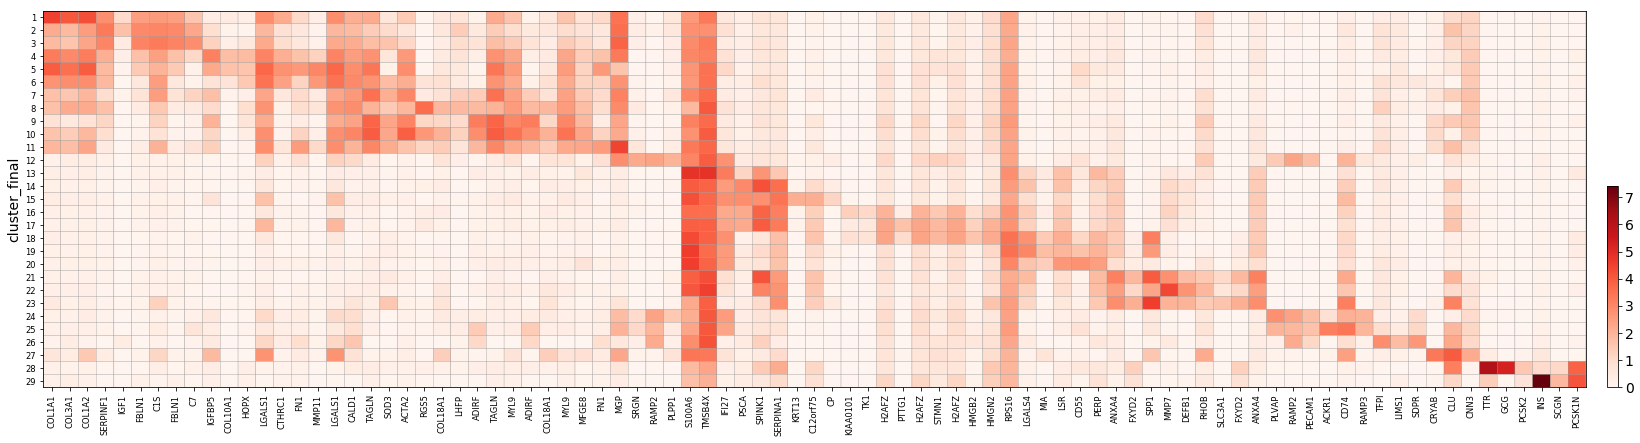

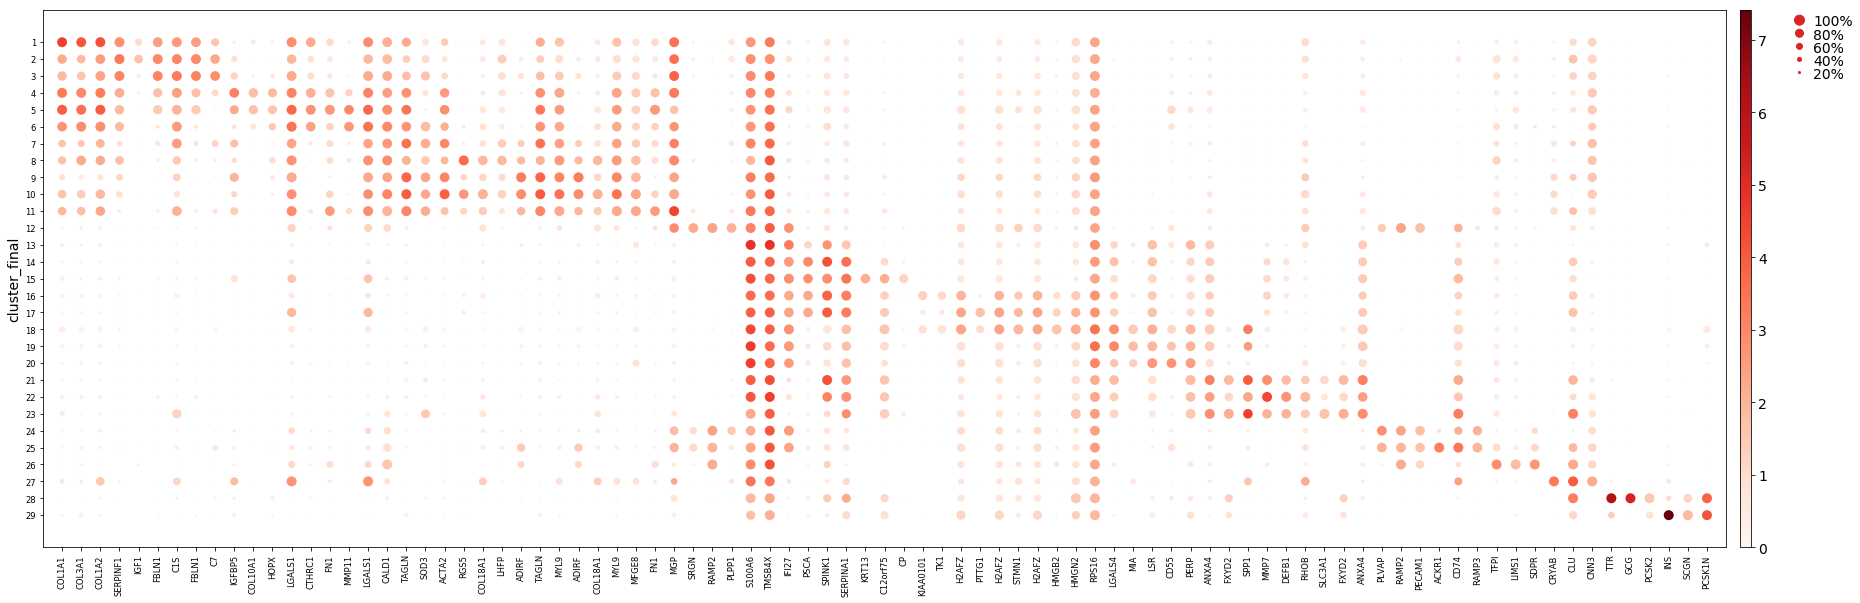

In [43]:
top3_genes = markers.groupby("cluster_final").head(3).gene_name.values
sc.pl.matrixplot(adata_redux, top3_genes, groupby="cluster_final", log=True)
sc.pl.dotplot(adata_redux, top3_genes, groupby="cluster_final", log=True)
#sc.pl.heatmap(adata_redux, top3_genes, groupby="cluster_R3", log=True)

In [44]:
sc.export_markers(adata_redux, "cluster_final")

CSV file saved to [/fastscratch/flynnb/test-outputs/PR18031_markers_20190128.csv].
Excel file saved to [/fastscratch/flynnb/test-outputs/PR18031_markers_20190128.xlsx].


## Report generation

Report generation happens in 5 steps.
1. Create the `SCBLReport` object.
2. Generate and capture report quality QC figures into variables.
3. Capture figures as base64 encoded strings and save them into `adata` using `report.add_report_figures(...)`.
4. Pass the `adata` object to `report.generate_report` to generate the report HTML.
5. (Not implemented) Transform HTML report to a pdf

In [45]:
report = sc.SCBLReport()

In [46]:
report.add_report_figures(adata_redux, 
                          violins=qc_fig1, 
                          scatters=qc_fig2,
                          ranks=[qc_fig3],
                          cluster_key="cluster")#_R3")

In [47]:
report.generate_report(adata_redux)

HTML report saved to [/fastscratch/flynnb/test-outputs/PR18031_20190128_report.html].


In [ ]:
# Not working currently and we're not giving this to customers.
report.generate_pdf()

## Saving outputs

Ultimately, the Rds file just holds 3 data frames, `log2cpm`, `featuredata`, and `tnse.data`.  Instead of taking a load of bloaty R code to do this, from now on we will just export these data to csv then submit a job to helix that will generate the Rds from these files.  However, we include job submission of this file here.

In [ ]:
sc.save_adata_to_rds(adata_redux, cluster_key="cluster_R3")

In [ ]:
full_save_file = sc.save_adata(adata_full, "full")
redux_save_file = sc.save_adata(adata_redux, "redux")
# OR
#sc.save_all_adata()

Additionally, if there is a customer that is computationally savy and uses R, we can save the final data structure as a [loom file](http://linnarssonlab.org/loompy/index.html).

In [ ]:
sc.save_loom(adata_redux)